In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'trainset/J0003_0024_0222_20110307012737_cell_1.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,1,0.259,2.23,-20
1,1,0.260,2.23,-20
2,1,0.259,2.23,-20
3,1,0.259,2.23,-20
4,1,0.259,2.23,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


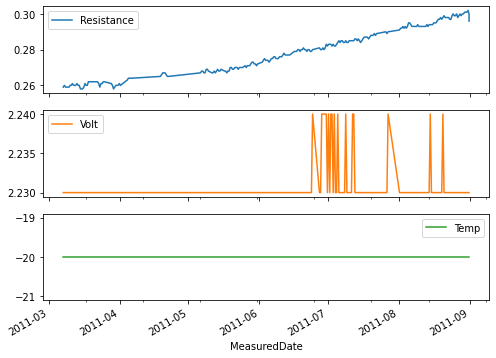

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

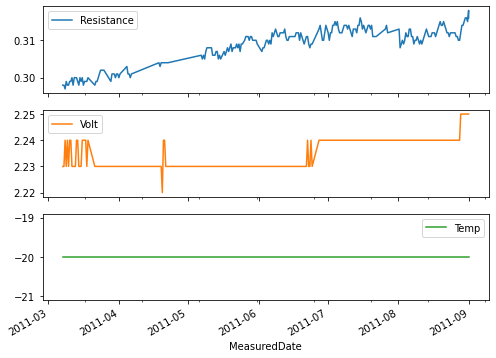

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,259.0,1.000000,0.000000,1.000,1.000,1.000,1.0000,1.000
Resistance,259.0,0.278544,0.012893,0.258,0.268,0.279,0.2895,0.302
Volt,259.0,2.230656,0.002481,2.230,2.230,2.230,2.2300,2.240
Temp,259.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.0000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.022727,0.0,0.0
1,0.045455,0.0,0.0
2,0.022727,0.0,0.0
3,0.022727,0.0,0.0
4,0.022727,0.0,0.0


<AxesSubplot:>

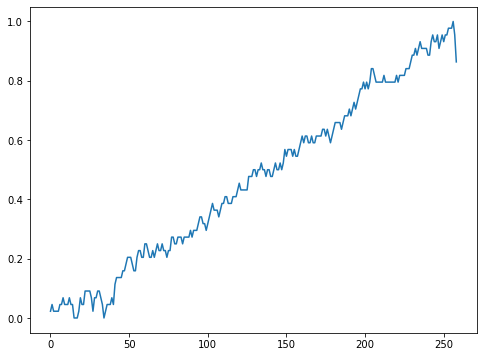

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
   # max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

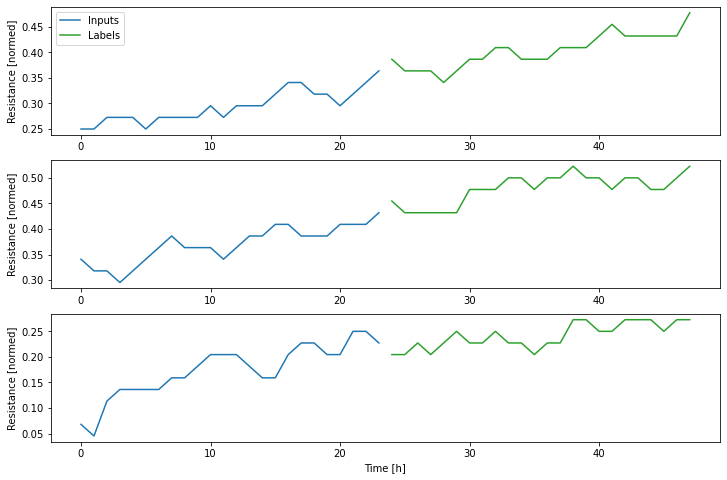

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 600

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/600
5/5 [==============================] - 4s 480ms/step - loss: 0.0806 - mean_absolute_error: 0.1494
Epoch 2/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0786 - mean_absolute_error: 0.1507
Epoch 3/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0733 - mean_absolute_error: 0.1469
Epoch 4/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0694 - mean_absolute_error: 0.1494
Epoch 5/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0465 - mean_absolute_error: 0.1277
Epoch 6/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0381 - mean_absolute_error: 0.1204
Epoch 7/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0340 - mean_absolute_error: 0.1134
Epoch 8/600
5/5 [==============================] - 0s 27ms/step - loss: 0.0310 - mean_absolute_error: 0.0911
Epoch 9/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0270 - mean_absolute_error: 0.0714
Epoch 10/600
5/5 [

Epoch 34/600
5/5 [==============================] - 0s 31ms/step - loss: 0.0243 - mean_absolute_error: 0.0664
Epoch 35/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0228 - mean_absolute_error: 0.0645
Epoch 36/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0210 - mean_absolute_error: 0.0613
Epoch 37/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0261 - mean_absolute_error: 0.0706
Epoch 38/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0202 - mean_absolute_error: 0.0600
Epoch 39/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0205 - mean_absolute_error: 0.0596
Epoch 40/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0222 - mean_absolute_error: 0.0629
Epoch 41/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0177 - mean_absolute_error: 0.0551
Epoch 42/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0232 - mean_absolute_error: 0.0670
Epoch 43/6

Epoch 67/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0157 - mean_absolute_error: 0.0481
Epoch 68/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0173 - mean_absolute_error: 0.0511
Epoch 69/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0197 - mean_absolute_error: 0.0557
Epoch 70/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0178 - mean_absolute_error: 0.0523
Epoch 71/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0151 - mean_absolute_error: 0.0480
Epoch 72/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0187 - mean_absolute_error: 0.0545
Epoch 73/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0163 - mean_absolute_error: 0.0492
Epoch 74/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0189 - mean_absolute_error: 0.0531
Epoch 75/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0189 - mean_absolute_error: 0.0542
Epoch 76/6

Epoch 100/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0163 - mean_absolute_error: 0.0458
Epoch 101/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0145 - mean_absolute_error: 0.0438
Epoch 102/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0148 - mean_absolute_error: 0.0438
Epoch 103/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0163 - mean_absolute_error: 0.0467
Epoch 104/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0157 - mean_absolute_error: 0.0458
Epoch 105/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0164 - mean_absolute_error: 0.0465
Epoch 106/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0169 - mean_absolute_error: 0.0473
Epoch 107/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0142 - mean_absolute_error: 0.0419
Epoch 108/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0163 - mean_absolute_error: 0.0464
E

Epoch 133/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0146 - mean_absolute_error: 0.0418
Epoch 134/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0154 - mean_absolute_error: 0.0433
Epoch 135/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0141 - mean_absolute_error: 0.0410
Epoch 136/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0133 - mean_absolute_error: 0.0393
Epoch 137/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0138 - mean_absolute_error: 0.0397
Epoch 138/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0165 - mean_absolute_error: 0.0445
Epoch 139/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0156 - mean_absolute_error: 0.0433
Epoch 140/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0182 - mean_absolute_error: 0.0464
Epoch 141/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0158 - mean_absolute_error: 0.0438
E

Epoch 166/600
5/5 [==============================] - 0s 32ms/step - loss: 0.0136 - mean_absolute_error: 0.0392
Epoch 167/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0143 - mean_absolute_error: 0.0398
Epoch 168/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0150 - mean_absolute_error: 0.0414
Epoch 169/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0143 - mean_absolute_error: 0.0398
Epoch 170/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0136 - mean_absolute_error: 0.0385
Epoch 171/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0141 - mean_absolute_error: 0.0384
Epoch 172/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0156 - mean_absolute_error: 0.0417
Epoch 173/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0151 - mean_absolute_error: 0.0409
Epoch 174/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0137 - mean_absolute_error: 0.0383
E

Epoch 199/600
5/5 [==============================] - 0s 27ms/step - loss: 0.0150 - mean_absolute_error: 0.0403
Epoch 200/600
5/5 [==============================] - 0s 28ms/step - loss: 0.0143 - mean_absolute_error: 0.0375
Epoch 201/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0145 - mean_absolute_error: 0.0385
Epoch 202/600
5/5 [==============================] - 0s 29ms/step - loss: 0.0146 - mean_absolute_error: 0.0395
Epoch 203/600
5/5 [==============================] - 0s 30ms/step - loss: 0.0131 - mean_absolute_error: 0.0360
Epoch 204/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0151 - mean_absolute_error: 0.0392
Epoch 205/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0145 - mean_absolute_error: 0.0402
Epoch 206/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0150 - mean_absolute_error: 0.0410
Epoch 207/600
5/5 [==============================] - 0s 29ms/step - loss: 0.0137 - mean_absolute_error: 0.0379
E

Epoch 232/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0145 - mean_absolute_error: 0.0391
Epoch 233/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0154 - mean_absolute_error: 0.0414
Epoch 234/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0130 - mean_absolute_error: 0.0364
Epoch 235/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0126 - mean_absolute_error: 0.0353
Epoch 236/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0143 - mean_absolute_error: 0.0385
Epoch 237/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0133 - mean_absolute_error: 0.0366
Epoch 238/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0138 - mean_absolute_error: 0.0374
Epoch 239/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0120 - mean_absolute_error: 0.0339
Epoch 240/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0137 - mean_absolute_error: 0.0370
E

Epoch 265/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0143 - mean_absolute_error: 0.0381
Epoch 266/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0116 - mean_absolute_error: 0.0337
Epoch 267/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0121 - mean_absolute_error: 0.0344
Epoch 268/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0119 - mean_absolute_error: 0.0342
Epoch 269/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0151 - mean_absolute_error: 0.0399
Epoch 270/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0147 - mean_absolute_error: 0.0393
Epoch 271/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0125 - mean_absolute_error: 0.0348
Epoch 272/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0145 - mean_absolute_error: 0.0383
Epoch 273/600
5/5 [==============================] - 0s 27ms/step - loss: 0.0136 - mean_absolute_error: 0.0368
E

Epoch 298/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0129 - mean_absolute_error: 0.0358
Epoch 299/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0120 - mean_absolute_error: 0.0340
Epoch 300/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0127 - mean_absolute_error: 0.0350
Epoch 301/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0131 - mean_absolute_error: 0.0359
Epoch 302/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0135 - mean_absolute_error: 0.0365
Epoch 303/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0142 - mean_absolute_error: 0.0380
Epoch 304/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0134 - mean_absolute_error: 0.0357
Epoch 305/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0129 - mean_absolute_error: 0.0352
Epoch 306/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0145 - mean_absolute_error: 0.0370
E

Epoch 331/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0124 - mean_absolute_error: 0.0345
Epoch 332/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0119 - mean_absolute_error: 0.0335
Epoch 333/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0130 - mean_absolute_error: 0.0355
Epoch 334/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0144 - mean_absolute_error: 0.0385
Epoch 335/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0132 - mean_absolute_error: 0.0356
Epoch 336/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0141 - mean_absolute_error: 0.0374
Epoch 337/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0140 - mean_absolute_error: 0.0377
Epoch 338/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0136 - mean_absolute_error: 0.0366
Epoch 339/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0127 - mean_absolute_error: 0.0348
E

Epoch 364/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0132 - mean_absolute_error: 0.0359
Epoch 365/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0134 - mean_absolute_error: 0.0359
Epoch 366/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0125 - mean_absolute_error: 0.0342
Epoch 367/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0116 - mean_absolute_error: 0.0321
Epoch 368/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0140 - mean_absolute_error: 0.0369
Epoch 369/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0140 - mean_absolute_error: 0.0372
Epoch 370/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0136 - mean_absolute_error: 0.0355
Epoch 371/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0133 - mean_absolute_error: 0.0365
Epoch 372/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0126 - mean_absolute_error: 0.0355
E

Epoch 397/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0136 - mean_absolute_error: 0.0369
Epoch 398/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0135 - mean_absolute_error: 0.0363
Epoch 399/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0138 - mean_absolute_error: 0.0370
Epoch 400/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0119 - mean_absolute_error: 0.0335
Epoch 401/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0128 - mean_absolute_error: 0.0348
Epoch 402/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0133 - mean_absolute_error: 0.0362
Epoch 403/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0123 - mean_absolute_error: 0.0343
Epoch 404/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0136 - mean_absolute_error: 0.0368
Epoch 405/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0135 - mean_absolute_error: 0.0362
E

Epoch 430/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0128 - mean_absolute_error: 0.0349
Epoch 431/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0117 - mean_absolute_error: 0.0331
Epoch 432/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0145 - mean_absolute_error: 0.0378
Epoch 433/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0145 - mean_absolute_error: 0.0370
Epoch 434/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0138 - mean_absolute_error: 0.0357
Epoch 435/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0147 - mean_absolute_error: 0.0366
Epoch 436/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0138 - mean_absolute_error: 0.0369
Epoch 437/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0144 - mean_absolute_error: 0.0382
Epoch 438/600
5/5 [==============================] - 0s 21ms/step - loss: 0.0129 - mean_absolute_error: 0.0350
E

Epoch 463/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0133 - mean_absolute_error: 0.0363
Epoch 464/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0139 - mean_absolute_error: 0.0372
Epoch 465/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0129 - mean_absolute_error: 0.0355
Epoch 466/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0131 - mean_absolute_error: 0.0357
Epoch 467/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0118 - mean_absolute_error: 0.0332
Epoch 468/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0130 - mean_absolute_error: 0.0355
Epoch 469/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0138 - mean_absolute_error: 0.0365
Epoch 470/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0113 - mean_absolute_error: 0.0327
Epoch 471/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0141 - mean_absolute_error: 0.0366
E

Epoch 496/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0130 - mean_absolute_error: 0.0354
Epoch 497/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0130 - mean_absolute_error: 0.0355
Epoch 498/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0125 - mean_absolute_error: 0.0345
Epoch 499/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0120 - mean_absolute_error: 0.0335
Epoch 500/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0116 - mean_absolute_error: 0.0331
Epoch 501/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0115 - mean_absolute_error: 0.0331
Epoch 502/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0105 - mean_absolute_error: 0.0303
Epoch 503/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0115 - mean_absolute_error: 0.0324
Epoch 504/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0117 - mean_absolute_error: 0.0327
E

Epoch 529/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0126 - mean_absolute_error: 0.0340
Epoch 530/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0140 - mean_absolute_error: 0.0395
Epoch 531/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0126 - mean_absolute_error: 0.0342
Epoch 532/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0125 - mean_absolute_error: 0.0353
Epoch 533/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0115 - mean_absolute_error: 0.0322
Epoch 534/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0121 - mean_absolute_error: 0.0340
Epoch 535/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0116 - mean_absolute_error: 0.0331
Epoch 536/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0125 - mean_absolute_error: 0.0348
Epoch 537/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0134 - mean_absolute_error: 0.0371
E

Epoch 562/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0112 - mean_absolute_error: 0.0314
Epoch 563/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0145 - mean_absolute_error: 0.0382
Epoch 564/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0145 - mean_absolute_error: 0.0371
Epoch 565/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0100 - mean_absolute_error: 0.0300
Epoch 566/600
5/5 [==============================] - 0s 22ms/step - loss: 0.0112 - mean_absolute_error: 0.0327
Epoch 567/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0118 - mean_absolute_error: 0.0330
Epoch 568/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0119 - mean_absolute_error: 0.0339
Epoch 569/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0125 - mean_absolute_error: 0.0350
Epoch 570/600
5/5 [==============================] - 0s 26ms/step - loss: 0.0127 - mean_absolute_error: 0.0351
E

Epoch 595/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0099 - mean_absolute_error: 0.0297
Epoch 596/600
5/5 [==============================] - 0s 24ms/step - loss: 0.0108 - mean_absolute_error: 0.0314
Epoch 597/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0112 - mean_absolute_error: 0.0320
Epoch 598/600
5/5 [==============================] - 0s 23ms/step - loss: 0.0106 - mean_absolute_error: 0.0315
Epoch 599/600
5/5 [==============================] - 0s 25ms/step - loss: 0.0104 - mean_absolute_error: 0.0311
Epoch 600/600
5/5 [==============================] - 0s 36ms/step - loss: 0.0114 - mean_absolute_error: 0.0328


In [23]:
#pred = model.predict(test_df)

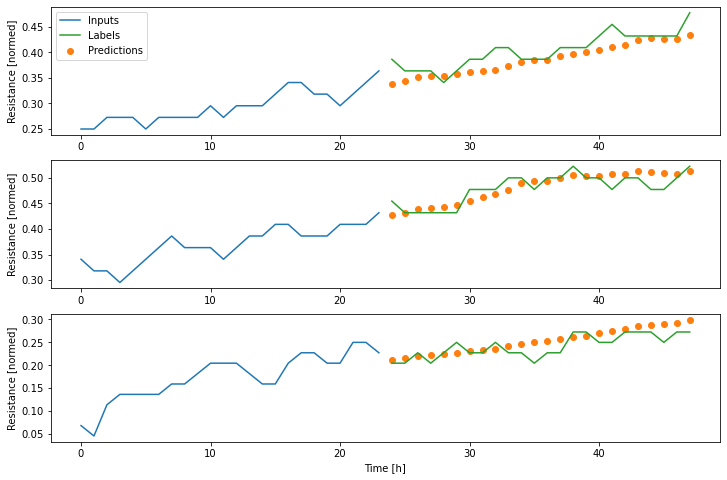

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [335]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [334]:
pred = model.predict(test_df_test)

ValueError: in user code:

    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 3)
